Fashion Editorial Classification and Recoloring¶
Deep Unsupervised Learning - Final Project
Yasaman Badeli. Catalina López B. Joao Vitor Peluzo Cardoso.

Professor: Ali Moridnejad.

Montreal, 2025.

References:
Data
https://www.kaggle.com/code/prites/starter-fashion-product-images-dataset-e4a4b7fb-7/notebook
https://www.kaggle.com/code/selvasubramanians/download-images-from-url/notebook
https://www.kaggle.com/datasets/vishalbsadanand/deepfashion-1?select=datasets
https://github.com/yousefiparsa/apparel-masking-color-detection/tree/master/examples
Models
https://huggingface.co/prithivMLmods/Fashion-Product-articleType
https://www.kaggle.com/code/vipulsharma2000/imaterialist-fashion-eda-object-detection-colors/notebook
https://osieardi.medium.com/no-cap-just-rgb-pythons-image-color-detection-3e06218d8531

## Download the images from CSV

In [ ]:
import pandas as pd
import json

# STEP 1: Load the CSV
csv_path = "/Users/catalinalopezbotina/Downloads/images.csv"  # Change this to your actual file
df = pd.read_csv(csv_path)

# STEP 2: Sample 10,000 entries randomly
sample_df = df.sample(n=10000, random_state=42).reset_index(drop=True)

# STEP 3: Convert to list of dictionaries
image_list = []
for _, row in sample_df.iterrows():
    image_entry = {
        "imageId": row["filename"],  # Replace with your actual column name if different
        "url": row["link"]
    }
    image_list.append(image_entry)

# STEP 4: Save to JSON file
output_path = "/Users/catalinalopezbotina/Downloads/sampled_images_10000.json"
with open(output_path, "w") as f:
    json.dump({"images": image_list}, f, indent=2)

print(f"✅ Saved 10,000 random samples to {output_path}")


In [ ]:
import os
import json
import requests
from PIL import Image, UnidentifiedImageError
from io import BytesIO
from tqdm import tqdm
import pandas as pd

# === Config ===
json_path = "/Users/catalinalopezbotina/Downloads/sampled_images_10000.json"
output_folder = "/Users/catalinalopezbotina/Downloads/vae_images_cleaned"
os.makedirs(output_folder, exist_ok=True)

# === Step 1: Load JSON ===
with open(json_path, "r") as f:
    data = json.load(f)

image_entries = data["images"]
print(f"Found {len(image_entries)} image entries.")

# === Step 2: Download images and preprocess ===
valid_entries = []

for item in tqdm(image_entries, desc="Downloading Images"):
    url = item.get("url")
    image_id = str(item.get("imageId"))

    try:
        response = requests.get(url, timeout=10)
        if "image" not in response.headers.get("Content-Type", ""):
            continue

        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((128, 128))  # Resize
        img_path = os.path.join(output_folder, f"{image_id}.jpg")
        img.save(img_path)

        # Add local path
        valid_entries.append({
            "imageId": image_id,
            "url": url,
            "local_path": img_path
        })

        # Optional early stop for test runs
        # if len(valid_entries) >= 1000:
        #     break

    except Exception:
        continue

print(f"✅ Downloaded {len(valid_entries)} valid images!")

# === Step 3: Save cleaned metadata ===
with open("cleaned_vae_images.json", "w") as f:
    json.dump(valid_entries, f, indent=2)

# Save CSV version too
df = pd.DataFrame(valid_entries)
df.to_csv("cleaned_vae_images.csv", index=False)

## Trainning model 

In [23]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class FashionImageDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_files = [f for f in os.listdir(folder_path) if f.endswith(".jpg")]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.folder_path, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = FashionImageDataset("./vae_images_cleaned", transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 64x64
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16x16
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*16*16, latent_dim)
        self.fc_logvar = nn.Linear(128*16*16, latent_dim)

        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128*16*16)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (128, 16, 16)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 64x64
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 128x128
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = self.decoder_input(z)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


In [24]:
import matplotlib.pyplot as plt

def show_reconstruction(model, dataloader):
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            recon, _, _ = model(batch)
            break
    # Undo normalization if you used [-1,1]
    def denorm(img):
        return (img * 0.5 + 0.5).clamp(0, 1)
    
    fig, axs = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axs[0, i].imshow(denorm(batch[i].permute(1,2,0)).cpu())
        axs[0, i].axis('off')
        axs[1, i].imshow(denorm(recon[i].permute(1,2,0)).cpu())
        axs[1, i].axis('off')
    axs[0, 0].set_ylabel('Original')
    axs[1, 0].set_ylabel('Reconstructed')
    plt.tight_layout()
    plt.show()


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=128).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=0.0005)

def loss_function_annealed(recon_x, x, mu, logvar, epoch, total_epochs):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_weight = min(1.0, epoch / (total_epochs / 2))  # Linear ramp-up
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss


In [9]:



# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    vae.train()
    total_loss = 0

    for images in dataloader:
        images = images.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon_images, mu, logvar = vae(images)

        # Loss
        loss = loss_function_annealed(recon_images, images, mu, logvar, epoch, num_epochs)


        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.2f}")


Epoch [1/20], Loss: 4.40
Epoch [2/20], Loss: 10.70
Epoch [3/20], Loss: 4.44
Epoch [4/20], Loss: 4.26
Epoch [5/20], Loss: 4.15
Epoch [6/20], Loss: 4.04
Epoch [7/20], Loss: 3.98
Epoch [8/20], Loss: 4.00
Epoch [9/20], Loss: 4.05
Epoch [10/20], Loss: 4.05
Epoch [11/20], Loss: 4.07
Epoch [12/20], Loss: 4.07
Epoch [13/20], Loss: 4.03
Epoch [14/20], Loss: 4.00
Epoch [15/20], Loss: 3.99
Epoch [16/20], Loss: 3.94
Epoch [17/20], Loss: 3.96
Epoch [18/20], Loss: 3.91
Epoch [19/20], Loss: 3.87
Epoch [20/20], Loss: 3.90


In [10]:
import matplotlib.pyplot as plt
import torch

def show_images(original, predicted, num_images=5):
    original = original[:num_images].cpu().detach()
    predicted = predicted[:num_images].cpu().detach()

    fig, axs = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        axs[0, i].imshow(original[i].permute(1, 2, 0))
        axs[0, i].set_title("Original")
        axs[0, i].axis("off")

        axs[1, i].imshow(predicted[i].permute(1, 2, 0))
        axs[1, i].set_title("Predicted")
        axs[1, i].axis("off")

    plt.tight_layout()
    plt.show()


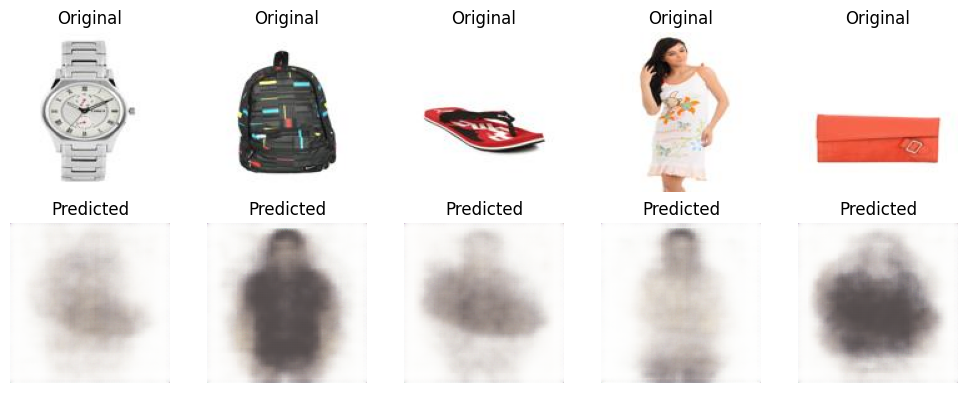

In [14]:
# Assuming you have a batch of images
real = next(iter(dataloader)).to(device)

# Pass through the model
recon, mu, logvar = vae(real)  # or output = generator(real)

# Show original vs predicted
show_images(real, recon)


## Mix VAEs GANs

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEGAN(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAEGAN, self).__init__()
        self.latent_dim = latent_dim
        
        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),  # [B, 64, 64, 64]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [B, 128, 32, 32]
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128*32*32, latent_dim)
        self.fc_logvar = nn.Linear(128*32*32, latent_dim)

        # --- Decoder ---
        self.decoder_fc = nn.Linear(latent_dim, 128*32*32)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [B, 64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),    # [B, 3, 128, 128]
            nn.Sigmoid()
        )

        # --- Discriminator ---
        self.discriminator = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128*32*32, 1),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(-1, 128, 32, 32)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [27]:
def vae_gan_loss(recon, real, mu, logvar, disc_fake, disc_real):
    # VAE loss
    recon_loss = F.mse_loss(recon, real, reduction='mean')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / real.size(0)

    # Adversarial loss (for generator)
    gen_loss = F.binary_cross_entropy(disc_fake, torch.ones_like(disc_fake))

    # Discriminator loss
    disc_loss_real = F.binary_cross_entropy(disc_real, torch.ones_like(disc_real))
    disc_loss_fake = F.binary_cross_entropy(disc_fake, torch.zeros_like(disc_fake))
    disc_loss = (disc_loss_real + disc_loss_fake) / 2

    return recon_loss + kl_loss + gen_loss, disc_loss


In [ ]:
vae_gan = VAEGAN(latent_dim=128).to(device)

opt_G = torch.optim.Adam(list(vae_gan.decoder.parameters()) +
                         list(vae_gan.fc_mu.parameters()) +
                         list(vae_gan.fc_logvar.parameters()), lr=1e-4)
opt_D = torch.optim.Adam(vae_gan.discriminator.parameters(), lr=1e-4)
epochs = 20
for epoch in range(epochs):
    for real in dataloader:
        real = real.to(device)

        # === Forward Pass ===
        recon, mu, logvar = vae_gan(real)
        disc_real = vae_gan.discriminator(real)
        disc_fake = vae_gan.discriminator(recon.detach())

        # === Update Discriminator ===
        opt_D.zero_grad()
        _, disc_loss = vae_gan_loss(recon, real, mu, logvar, disc_fake, disc_real)
        disc_loss.backward()
        opt_D.step()

        # === Update Generator / VAE ===
        recon, mu, logvar = vae_gan(real)
        disc_fake = vae_gan.discriminator(recon)
        opt_G.zero_grad()
        total_loss, _ = vae_gan_loss(recon, real, mu, logvar, disc_fake, disc_real)
        total_loss.backward()
        opt_G.step()
